In [2]:
import numpy as np
from sklearn import metrics
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, datasets
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [3]:
print(f"Is GPU available? {torch.cuda.is_available()}")
print(f"Number of available devices: {torch.cuda.device_count()}")
print(f"Index of current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Is GPU available? True
Number of available devices: 1
Index of current device: 0
Device name: NVIDIA GeForce GTX 1650 with Max-Q Design


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#the writer seems to be unused right now, however I kept them in the code in the "training" section

#defaults
BATCH_SIZE = 128
N_EPOCHS = 10
LEARNING_RATE = 0.001

# Nacitanie dat

In [5]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

class notMNIST(Dataset):
    def __init__(self, data, labels):
        self.images = data
        self.labels = labels

        self.transformation = transforms.Compose([
                                                  
            transforms.ToTensor(),
            transforms.ConvertImageDtype(dtype=torch.float32),
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        img_tensor = self.transformation(img)
        y_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor.view(1, 28, 28), y_tensor


data = loadmat('notMNIST_small.mat')
print(data.keys())

images = data['images']
labels = data['labels']

print(images.shape)
images = [images[:, :, i] for i in range(0, images.shape[2])]
images = np.asarray(images)
print(images.shape)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, shuffle=True)

train_dataset = notMNIST(x_train, y_train)
test_dataset = notMNIST(x_test, y_test)

trainloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])
(28, 28, 18724)
(18724, 28, 28)


# MLP Siet

In [6]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,10),
            nn.Softmax()
        )

    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = self.fc_layers(out)
        return out


# CNN Siet

In [7]:
class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(320, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10),
            nn.Softmax()
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(x.shape[0], -1)
        out = self.fc_layers(out)
        return out

# Resnet18

In [8]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc.out_features = 10
print(model.named_children)

count = 0
freeze_first_n_layers = 4
# freeze backbone layers
for param in model.children(): 
    if count < freeze_first_n_layers and len(list(param.parameters())) > 0: # freezing first 3 layers
        print(param)
        param.requires_grad_(False)
        count +=1      


C:\Users\micha\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\micha\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.named_children of ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

*Trenovacia funkcia*

In [9]:
def training_function(model, trainloader, writer, batch_size, n_epochs, learning_rate):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)

    model.train()

    acc_history = []
    loss_history = []
    final_labels = []
    final_predicted = []

    for epoch in trange(1, n_epochs + 1, desc="1st loop"):
        epoch_loss = 0
        n_batches = len(train_dataset) // batch_size
        correct = 0
        total = 0
        accuracy_train = 0

        for step, (images, labels) in enumerate(tqdm(trainloader, desc="Epoch {}/{}".format(epoch, N_EPOCHS))):

            images = images.to(device)
            labels = labels.to(device)
            
            # Dopredne sirenie, 
            # ziskame pravdepodobnosti tried tym, ze posleme do modelu vstupy
            outputs = model(images)

            # Vypocitame chybu algoritmu       
            loss = criterion(outputs, labels)
            
            # Uspesnost algoritmu
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy_train = correct / total
            epoch_loss += loss.item() 
            
            # Je vhodne zavolat zero_grad() pred zavolanim spatneho sirenia 
            # pre vynulovanie gradientov z predosleho volania loss.backward()
            optimizer.zero_grad()

            # Spatne sirenie chyby, vypocitaju sa gradienty
            loss.backward()
            
            # Aktualizacia vah pomocou optimalizatora
            optimizer.step()

            if step % n_batches == 0 and step != 0:
                epoch_loss = epoch_loss / n_batches

                writer.add_scalar(
                    'training loss',
                    epoch_loss,
                    epoch
                )
                
                writer.add_scalar(
                    'training accuracy',
                    accuracy_train,
                    epoch
                )

                acc_history.append(accuracy_train)
                loss_history.append(epoch_loss)
                print("Epoch {}, Loss {:.6f}, Accuracy {:.2f}% ".format(epoch, epoch_loss, accuracy_train * 100))
                epoch_loss = 0

                #to display knovolution kernels/filters?
                #print(model.layer1[0].conv1.weight[0][0])
                #print(model.layer2[0].conv1.weight[0][0])
                #print(model.layer3[0].conv1.weight[0][0])

            final_predicted += predicted.tolist()
            final_labels += labels.tolist()
            torch.cuda.empty_cache()

            #writing training data
            
    writer.add_hparams(
        {
        'optimizer': optimizer.__class__.__name__,
        'lr': LEARNING_RATE, 
        'batch_size': BATCH_SIZE
        },
        {
        'hparam/train/accuracy': accuracy_train,
        }
    )
    writer.close()

# Trenovanie

In [10]:
#to recycle previous code model is resnet

#writer = SummaryWriter('runs/experiment_55')

model_cnn_1 = CustomCNN()

model_mlp = MLP()
writer_mlp = SummaryWriter('./runs/experiment_MLP')

training_function(model_mlp,trainloader,writer_mlp,BATCH_SIZE,N_EPOCHS,LEARNING_RATE)




# model = CustomCNN()


1st loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/88 [00:00<?, ?it/s]

C:\Users\micha\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1, Loss 2.308039, Accuracy 17.89% 


Epoch 2/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2, Loss 2.309930, Accuracy 17.72% 


Epoch 3/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3, Loss 2.277902, Accuracy 20.90% 


Epoch 4/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4, Loss 2.269029, Accuracy 21.76% 


Epoch 5/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5, Loss 2.299614, Accuracy 18.77% 


Epoch 6/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6, Loss 2.333160, Accuracy 15.44% 


Epoch 7/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7, Loss 2.336183, Accuracy 15.14% 


Epoch 8/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8, Loss 2.324545, Accuracy 16.29% 


Epoch 9/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9, Loss 2.328783, Accuracy 15.89% 


Epoch 10/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10, Loss 2.311205, Accuracy 17.62% 


# Ukladanie modelu

In [13]:
PATH_MLP = "./model_mlp.pt"
PATH_CNN_1= "./model_cnn_1.pt"
PATH_CNN_2= "./model_cnn_2.pt"
PATH_CNN_resnet= "./model_cnn_resnet.pt"

#saving MLP
torch.save(model_mlp.state_dict(), PATH_MLP)

#torch.save(model.state_dict(), PATH)

# Nacitanie modelu

In [14]:
model = None
model = MLP()
model.load_state_dict(torch.load(PATH_MLP))
print(model)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=None)
  )
)


# Priebeh trenovania

*Vythianutie dat z logov ulozenych writerom, courtesy of chatgpt*

In [19]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# Specify the path to your SummaryWriter directory
log_dir = './runs/experiment_MLP'

# Get a list of event files (logs) in the directory
event_files = [os.path.join(log_dir, file) for file in os.listdir(log_dir) if file.startswith('events.out.tfevents.')]

# Sort event files by modification time (newest first)
event_files.sort(key=os.path.getmtime, reverse=True)

latest_event_file = event_files[0]

# Create an EventAccumulator for the specified log directory
event_acc = EventAccumulator(latest_event_file)

# Load the event data
event_acc.Reload()

# Get a list of available tags (scalar summaries)
scalar_tags = event_acc.Tags()['scalars']

# Read the data for a specific tag (e.g., 'training accuracy')
tag_to_read = 'training accuracy'
acc_history=[]


if tag_to_read in scalar_tags:
    # Get the events associated with the tag
    events = event_acc.Scalars(tag_to_read)

    # Extract the values and steps (epochs in this case)
    values = [event.value for event in events]
    steps = [event.step for event in events]

    # Now, 'values' contains the recorded accuracy values, and 'steps' contains the corresponding epoch numbers
    for step, value in zip(steps, values):
        print(f"Epoch {step}: Accuracy = {value}")
        acc_history.append(value)
else:
    print(f"Tag '{tag_to_read}' not found in scalar summaries.")
    
# Read the data for a specific tag (e.g., 'training accuracy')
tag_to_read = 'training loss'
loss_history=[]

if tag_to_read in scalar_tags:
    # Get the events associated with the tag
    events = event_acc.Scalars(tag_to_read)

    # Extract the values and steps (epochs in this case)
    values = [event.value for event in events]
    steps = [event.step for event in events]

    # Now, 'values' contains the recorded accuracy values, and 'steps' contains the corresponding epoch numbers
    for step, value in zip(steps, values):
        print(f"Epoch {step}: Loss = {value}")
        loss_history.append(value)
else:
    print(f"Tag '{tag_to_read}' not found in scalar summaries.")
    
    


Epoch 1: Accuracy = 0.17892113327980042
Epoch 2: Accuracy = 0.1772298365831375
Epoch 3: Accuracy = 0.2090083658695221
Epoch 4: Accuracy = 0.2176428735256195
Epoch 5: Accuracy = 0.18773366510868073
Epoch 6: Accuracy = 0.15444187819957733
Epoch 7: Accuracy = 0.15141534805297852
Epoch 8: Accuracy = 0.16289834678173065
Epoch 9: Accuracy = 0.1588926464319229
Epoch 10: Accuracy = 0.17616164684295654
Epoch 1: Loss = 2.308039426803589
Epoch 2: Loss = 2.3099300861358643
Epoch 3: Loss = 2.2779016494750977
Epoch 4: Loss = 2.269028663635254
Epoch 5: Loss = 2.2996139526367188
Epoch 6: Loss = 2.333160161972046
Epoch 7: Loss = 2.3361830711364746
Epoch 8: Loss = 2.3245444297790527
Epoch 9: Loss = 2.3287830352783203
Epoch 10: Loss = 2.3112053871154785


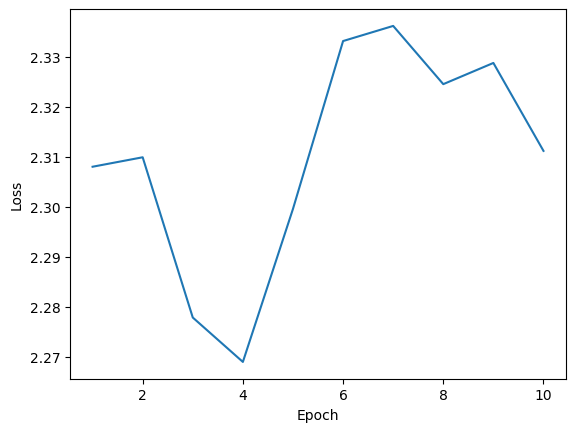

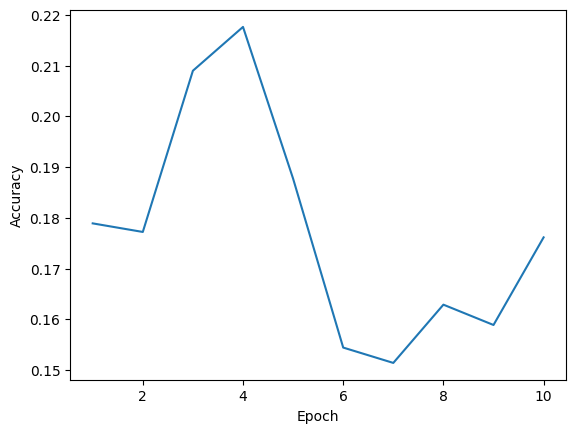

In [20]:
plt.plot(np.array(range(1, N_EPOCHS + 1)), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.array(range(1, N_EPOCHS + 1)), acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Testovanie modelu

In [21]:
model.eval()  # activate evaulation mode, some layers behave differently
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()
total = 0
correct = 0
final_labels = []
final_predicted = []
for inputs, labels in tqdm(iter(testloader), desc="Full forward pass", total=len(testloader)):
    if use_cuda:
        inputs = inputs.cuda()
        labels = labels.cuda()
    with torch.no_grad():
        outputs_batch = model(inputs)

    _, predicted = torch.max(outputs_batch.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    final_predicted += predicted.tolist()
    final_labels += labels.tolist()

print('Accuracy of the network on the test images: %0.2f %%' % (100 * correct / total))

Full forward pass:   0%|          | 0/59 [00:00<?, ?it/s]

C:\Users\micha\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on the test images: 19.20 %


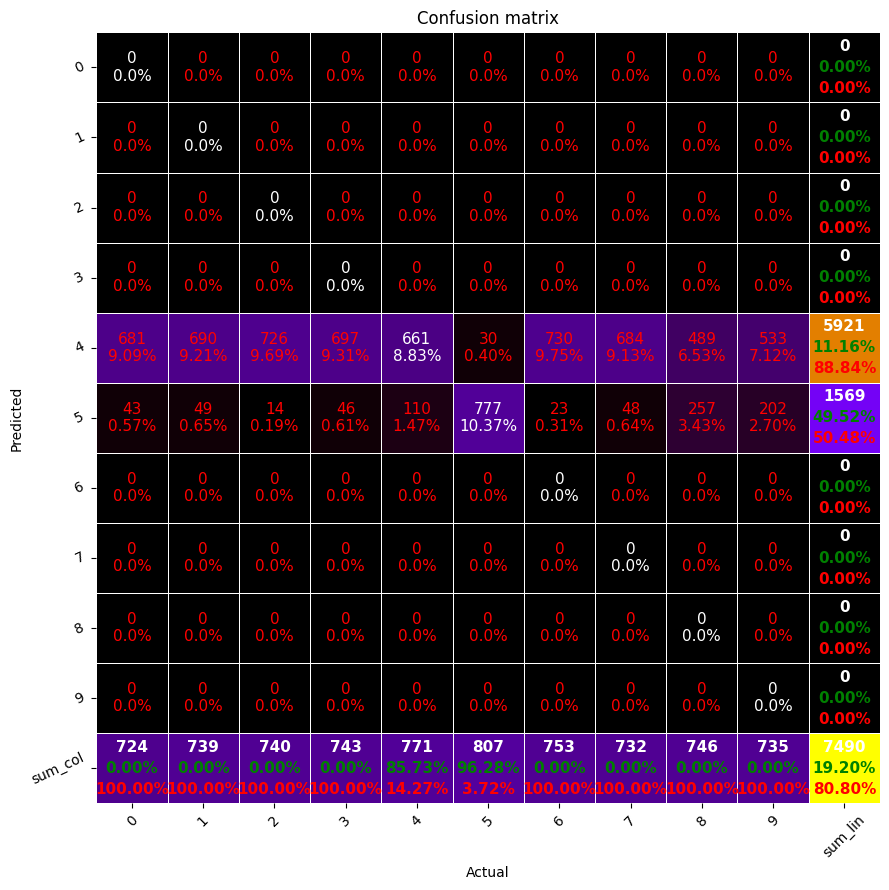

In [22]:
import numpy as np
from pretty_confusion_matrix import pp_matrix_from_data

y_test = final_labels
predic =  final_predicted

labels = [i for i in range(10)]

pp_matrix_from_data(y_test, predic, columns=labels, cmap="gnuplot")